In [18]:
import networkx as nx
import numpy as np
import networkx.algorithms.community as nx_comm
from utils import load_network
import itertools
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

G = load_network()
proteins = ['LIP5', 'LIP1', 'NFU1', 'LAT1']

In [19]:
comms = nx_comm.louvain_communities(G, resolution=1)

In [20]:
def construct_protein_to_community(comms):
    protein_community = dict()
    for idx, s in enumerate(comms):
        for p in s:
            protein_community[p]=idx
    return protein_community

protein_to_community = construct_protein_to_community(comms)
interested_comms = set(protein_to_community[p] for p in proteins)

In [21]:
def construct_reduced_graph(G, louvain_comms):
    '''
    given a graph G and its comomunities louvain_comms, constructs a reduced graph where
    each node in the reduced graph corresponds to a community in the original graph
    the edge weight between nodes in the reduced graph counts the number of nodes connecting the
    two corresponding communities in the original graph
    '''
    
    H = nx.Graph()
    # add one node for each community
    H.add_nodes_from(range(len(louvain_comms)))
    
    for comm1, comm2 in itertools.combinations(range(len(louvain_comms)), 2):
        # gets the edges connecting the two communities
        edges = list(nx.edge_boundary(G, louvain_comms[comm1], louvain_comms[comm2]))
        # the edge weight in the reduced graph is the number of edges that connect the two communities
        if len(edges) > 0:
            H.add_edge(comm1, comm2, weight=len(edges), weight_inverse=1/len(edges))
    
    # remove singleton nodes
    H.remove_nodes_from(list(nx.isolates(H)))
    return H
    
H = construct_reduced_graph(G, comms)

In [22]:
dict(H.degree(weight='weight'))

{0: 9070,
 1: 22432,
 3: 9573,
 4: 19530,
 6: 18027,
 10: 6130,
 12: 3312,
 14: 19204,
 15: 20092}

In [23]:
nx.betweenness_centrality(H, weight='weight')

{0: 0.0,
 1: 0.0,
 3: 0.0,
 4: 0.0,
 6: 0.0,
 10: 0.46428571428571425,
 12: 0.6785714285714285,
 14: 0.0,
 15: 0.0}

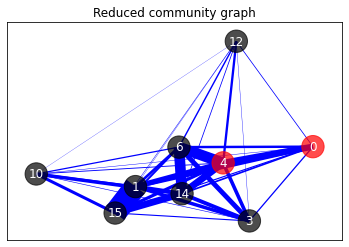

In [24]:
def draw_weighted_graph(G, interested_comms, ax):
    
    # https://stackoverflow.com/questions/62935983/vary-thickness-of-edges-based-on-weight-in-networkx
    widths = nx.get_edge_attributes(G, 'weight')
    nodelist = G.nodes()
    
    ax.set_title('Reduced community graph')
        
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=500,
                       node_color=['red' if n in interested_comms else 'black' for n in nodelist],
                       alpha=0.7,
                          ax=ax)
    nx.draw_networkx_edges(G,pos,
                           edgelist=widths.keys(),
                           width=list(map(lambda x: x/500, widths.values())),
                           edge_color='blue',
                           alpha=1,
                          ax=ax)
    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='white',
                           ax=ax)

draw_weighted_graph(H, interested_comms, plt.gca())

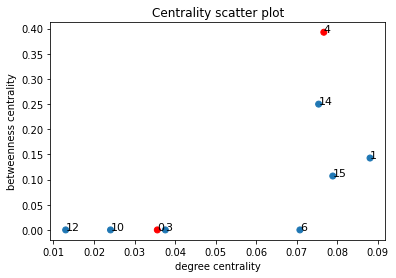

In [25]:
def plot_degree_centralities(G, interested_comms, degree1_func, name1, degree2_func, name2, ax):
    degree1 = degree1_func(G)
    degree2 = degree2_func(G)
    x = []
    y = []
    c = []
    for key, val in degree1.items():
        x.append(val)
        y.append(degree2[key])
        ax.annotate(key, (val, degree2[key]), fontsize=11)
        c.append('red' if key in interested_comms else '#1f77b4')
    ax.scatter(x, y, c=c)
    ax.set_xlabel(name1)
    ax.set_ylabel(name2)
    ax.set_title('Centrality scatter plot')

def weighted_degree(G):
    degrees = dict(G.degree(weight='weight'))
    total_weights = sum(degrees.values())
    for k in degrees:
        degrees[k] /= 2*total_weights
    return degrees
    
    
# note for the betweenness centrality we use 1/weight as the "weight" parameter which is interpreted as distance
# because high weights indicate closeness between communities, so we want the corresponding "weight"/distance to be smaller
plot_degree_centralities(H, interested_comms,
                         weighted_degree, 'degree centrality', 
                         partial(nx.betweenness_centrality, weight='weight_inverse'), 'betweenness centrality',
                        plt.gca())

In [30]:
def full_process(resolution, repeats, save_filename, louvain_seed=0):
    f, axs = plt.subplots(nrows=repeats, ncols=2, figsize=(6.4*2, 4.8*repeats))
    
    for i in tqdm(range(repeats)):
        comms = nx_comm.louvain_communities(G, resolution=resolution, seed=louvain_seed+i)
        protein_to_community = construct_protein_to_community(comms)
        interested_comms = set(protein_to_community[p] for p in proteins)
        H = construct_reduced_graph(G, comms)

        draw_weighted_graph(H, interested_comms, axs[i, 0])
        plot_degree_centralities(H, interested_comms,
                         weighted_degree, 'degree centrality', 
                         partial(nx.betweenness_centrality, weight='weight_inverse'), 'betweenness centrality',
                        axs[i,1])
        
    f.suptitle(f'Louvain resolution = {resolution}', fontsize='x-large')
    plt.savefig(save_filename)
# full_process(resolution=1, repeats=3, save_filename='reduced-subgraph-figs/test.svg')

100%|███████████████████████████████████████████| 16/16 [23:49<00:00, 89.36s/it]


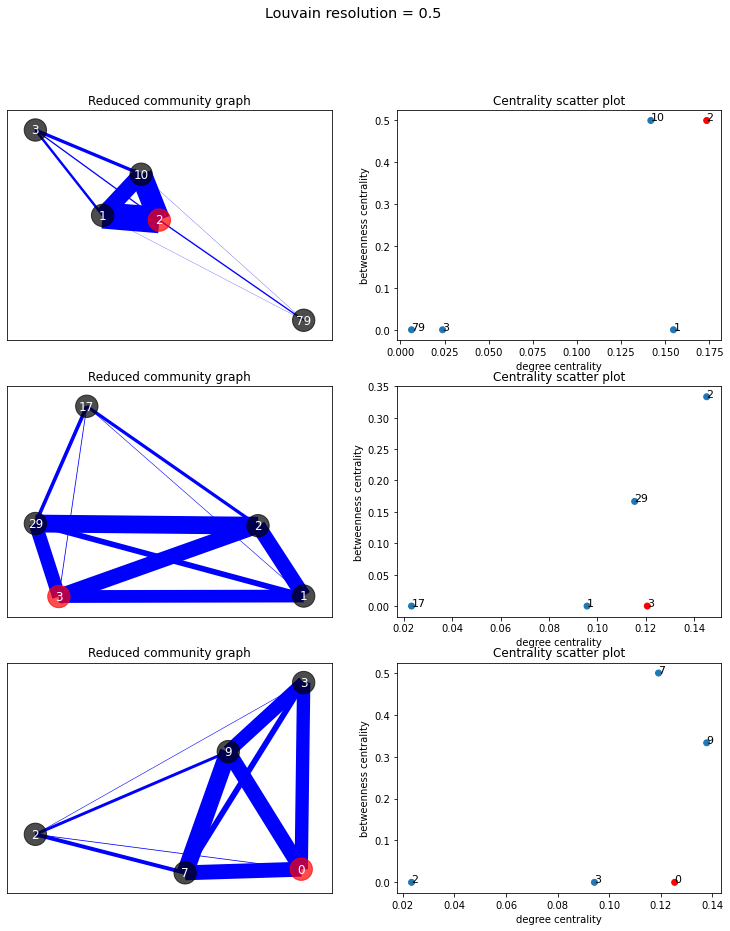

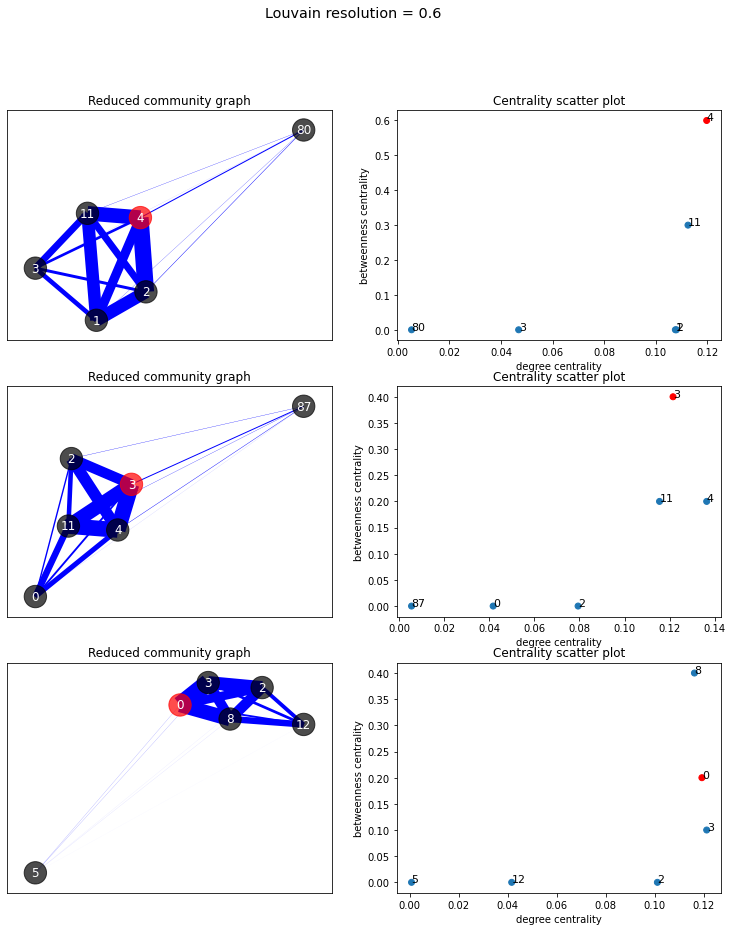

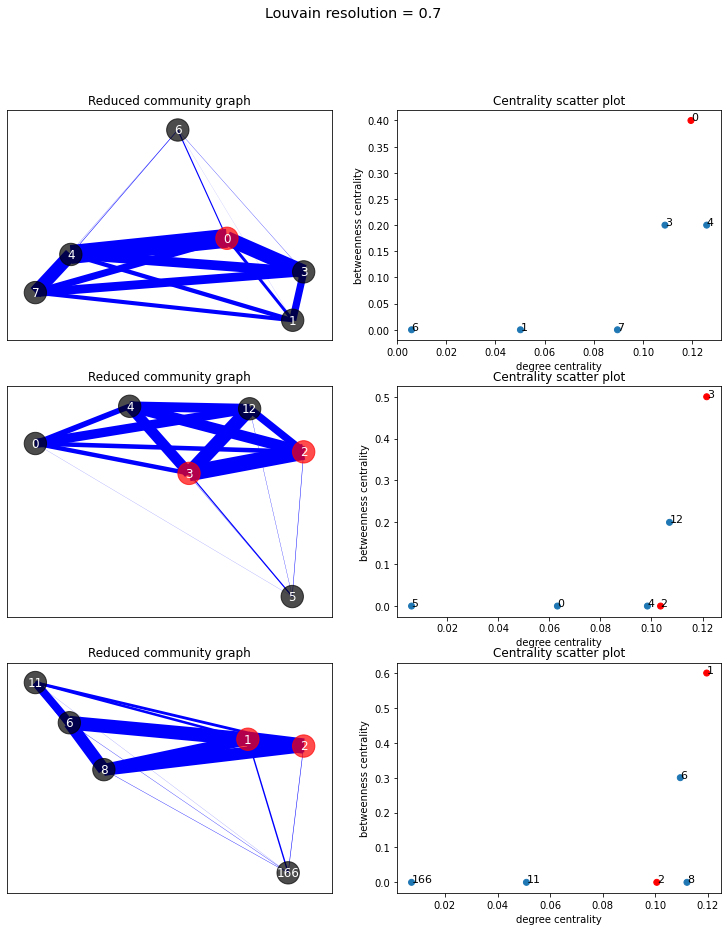

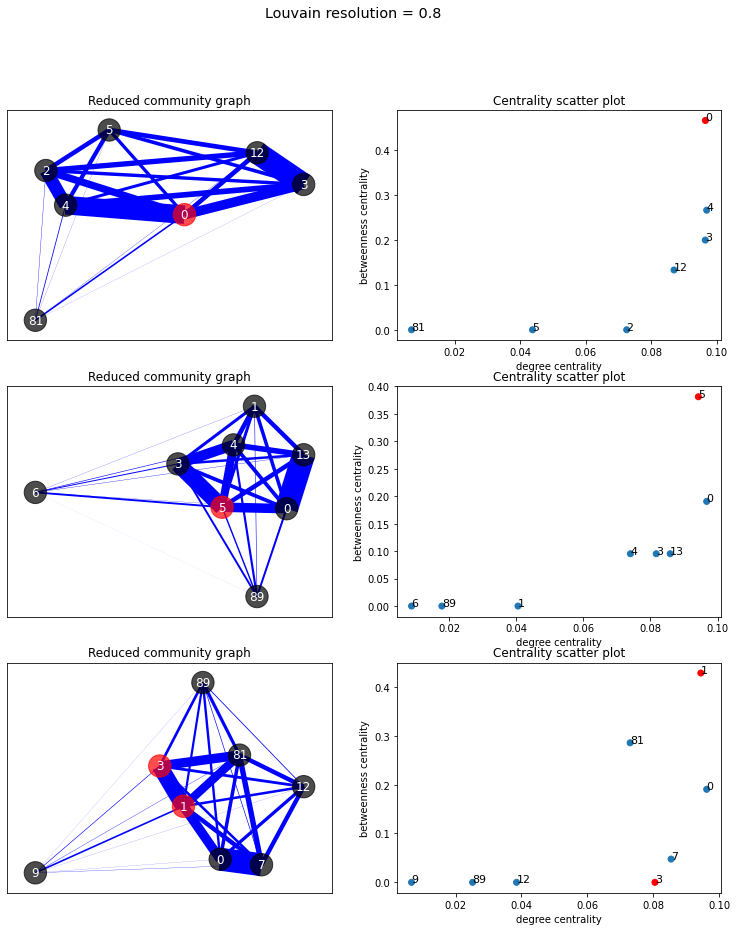

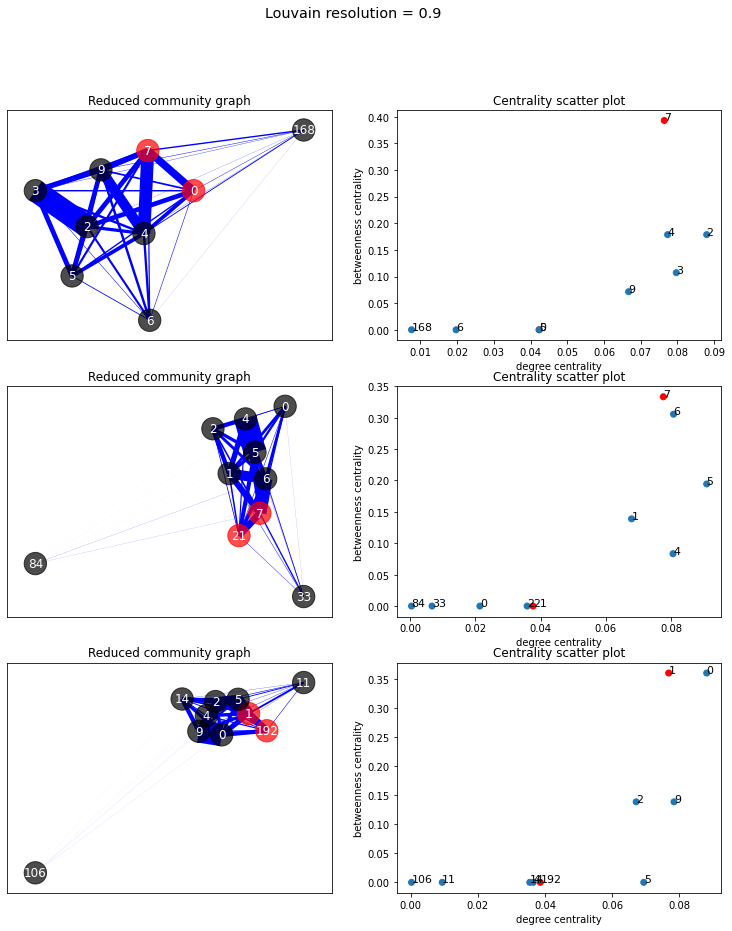

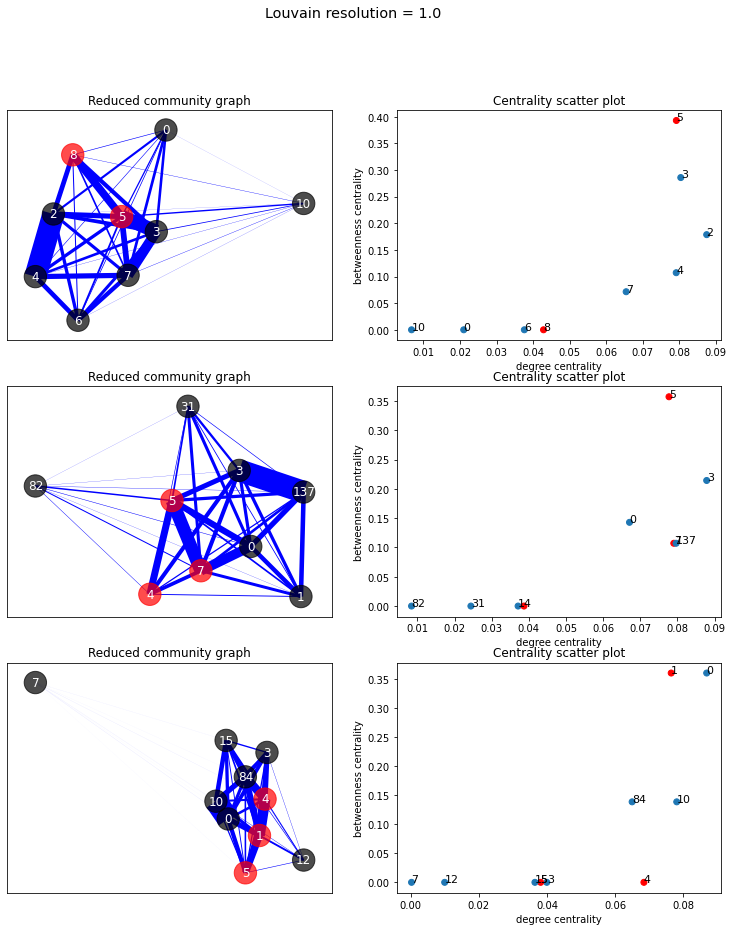

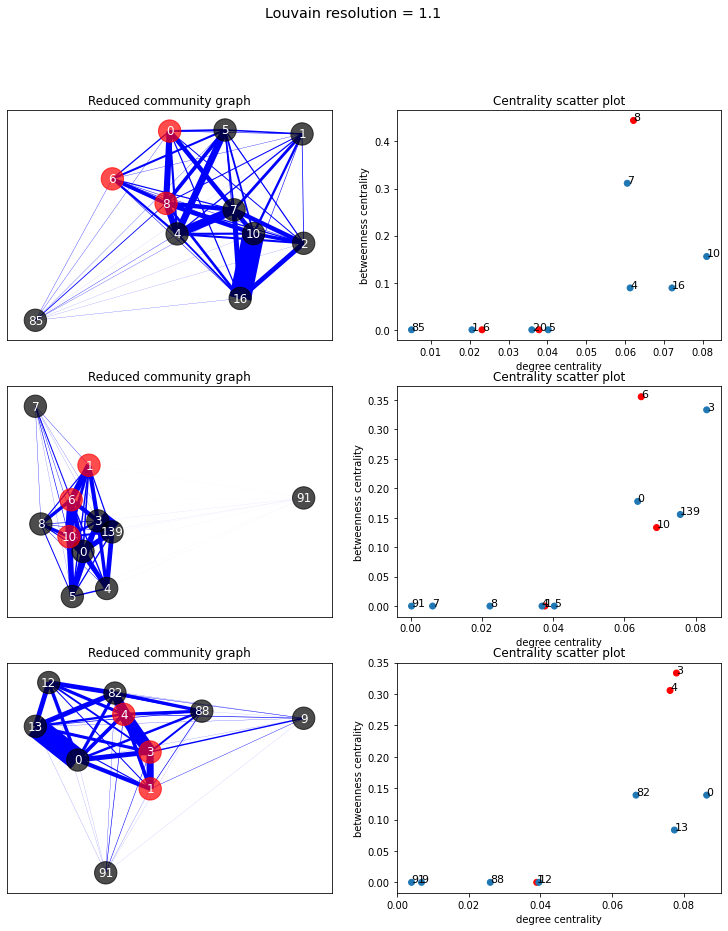

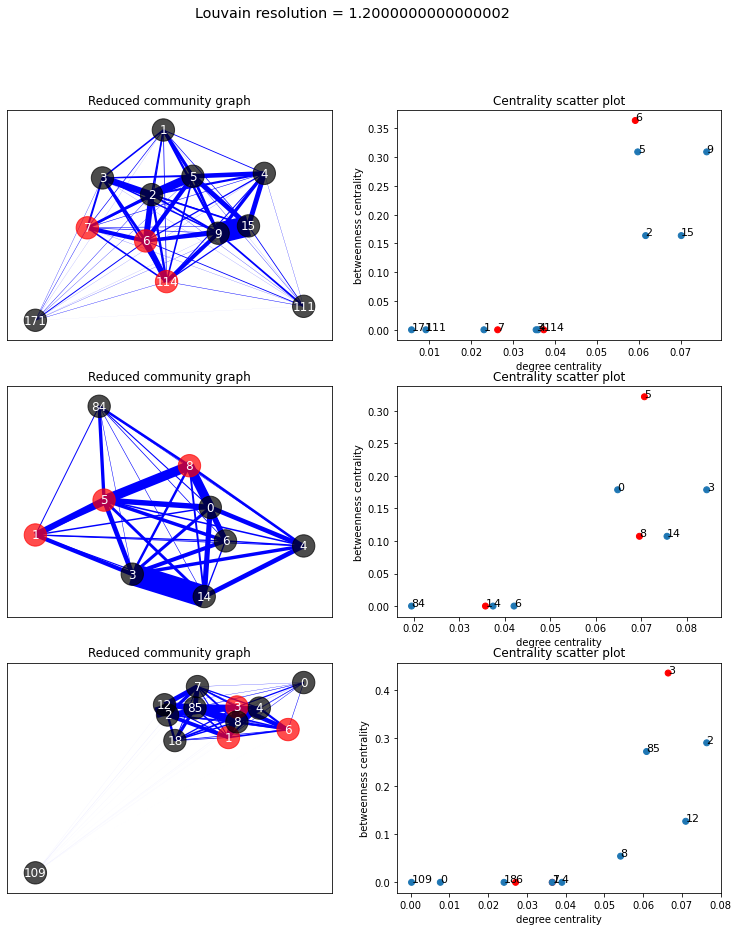

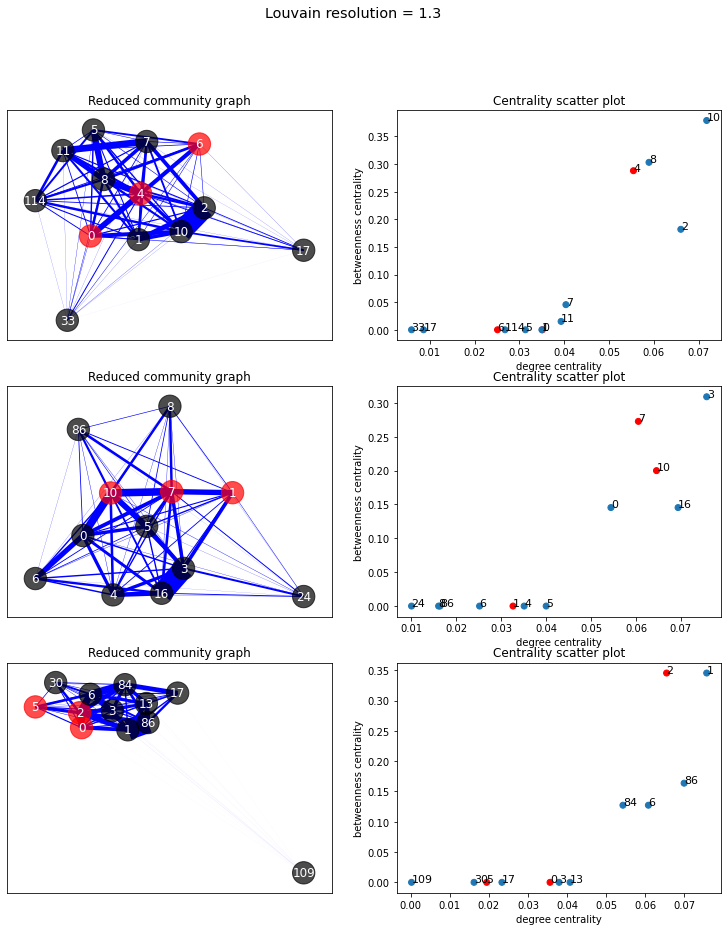

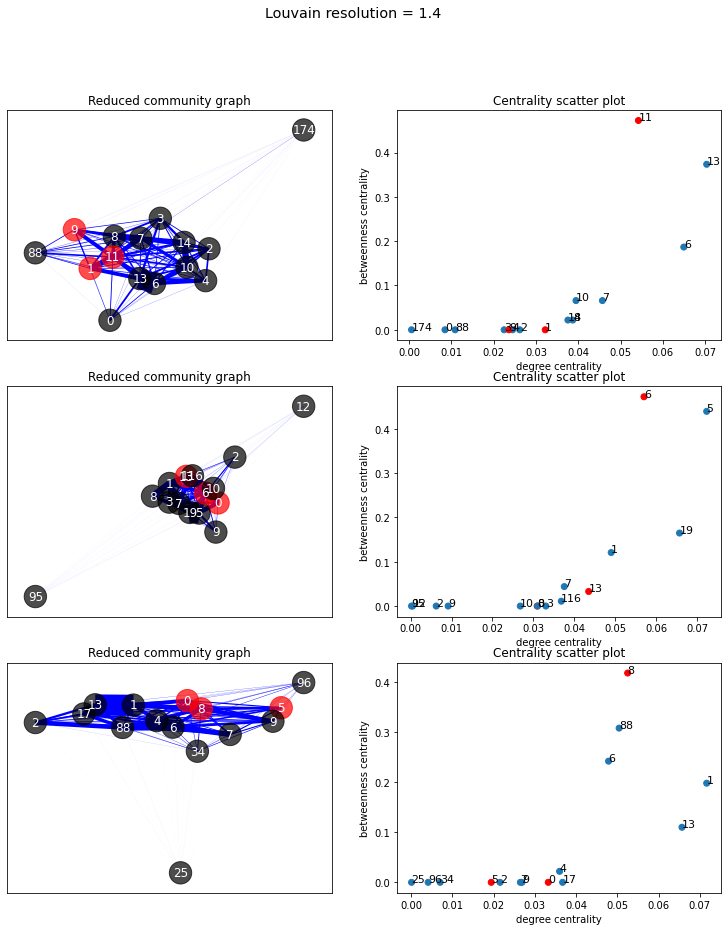

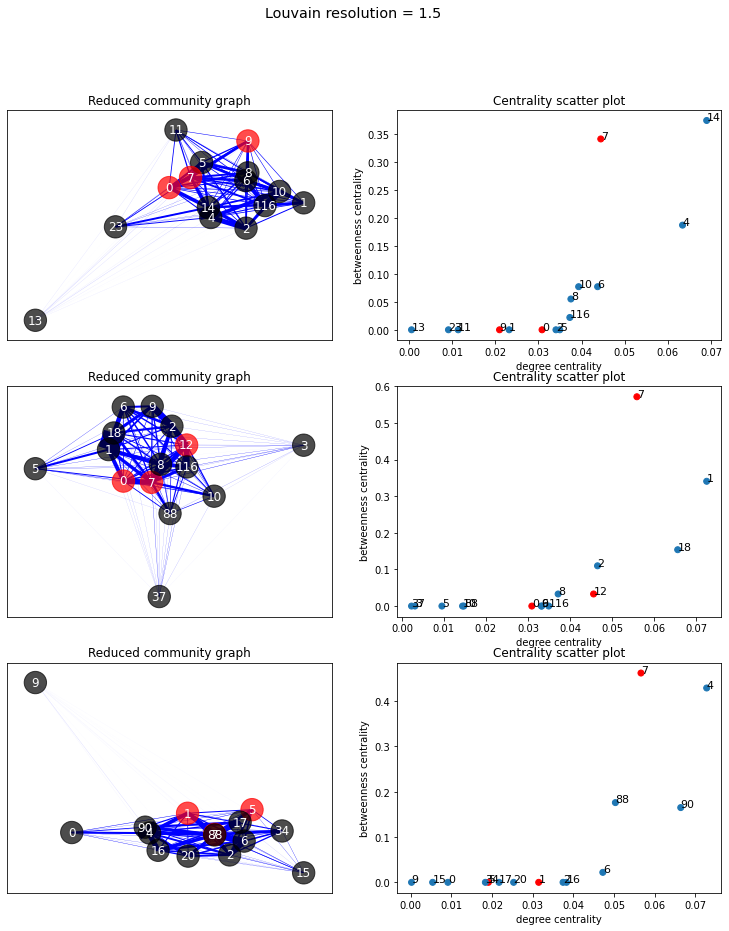

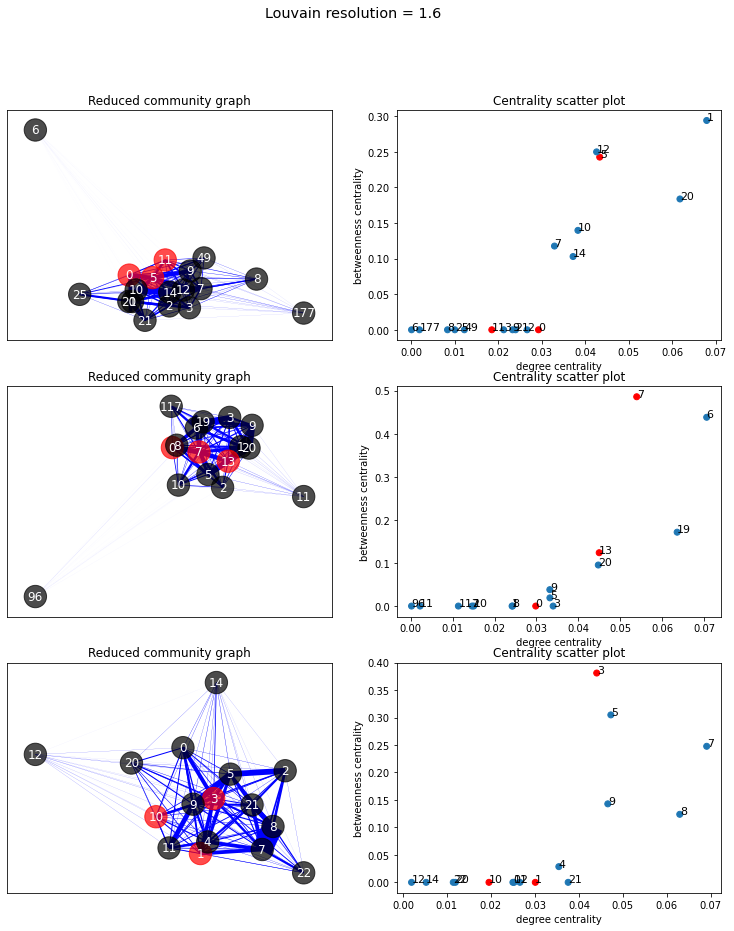

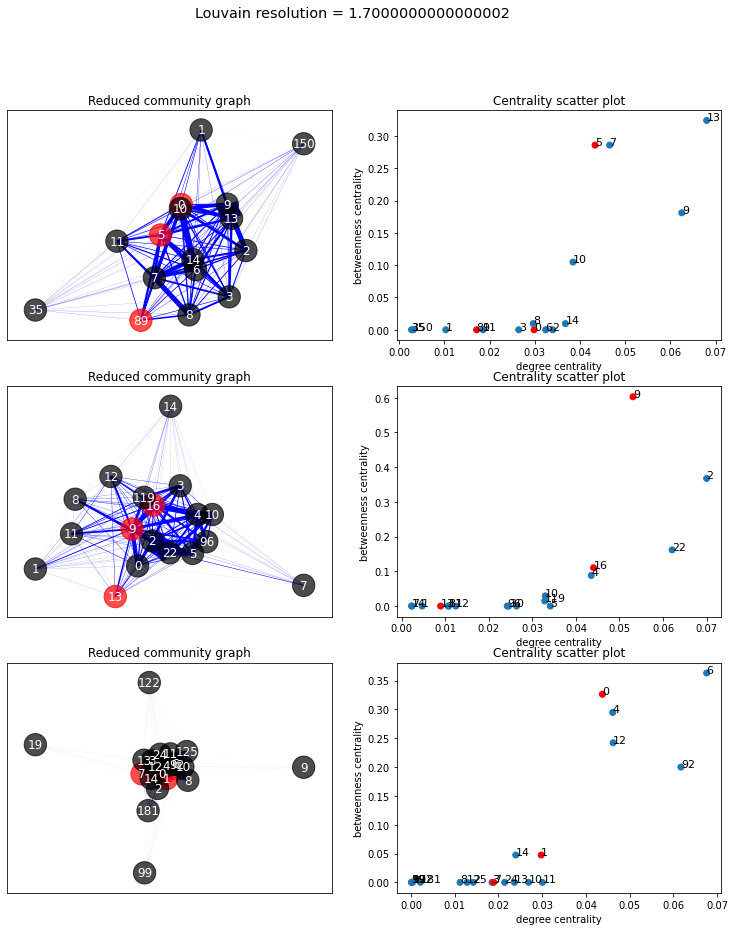

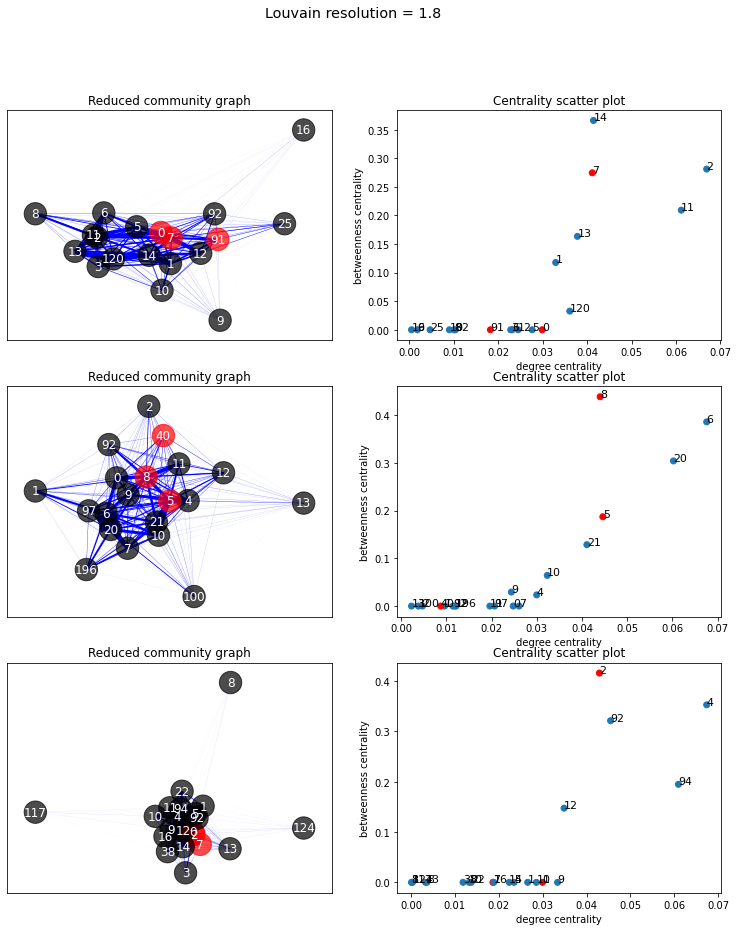

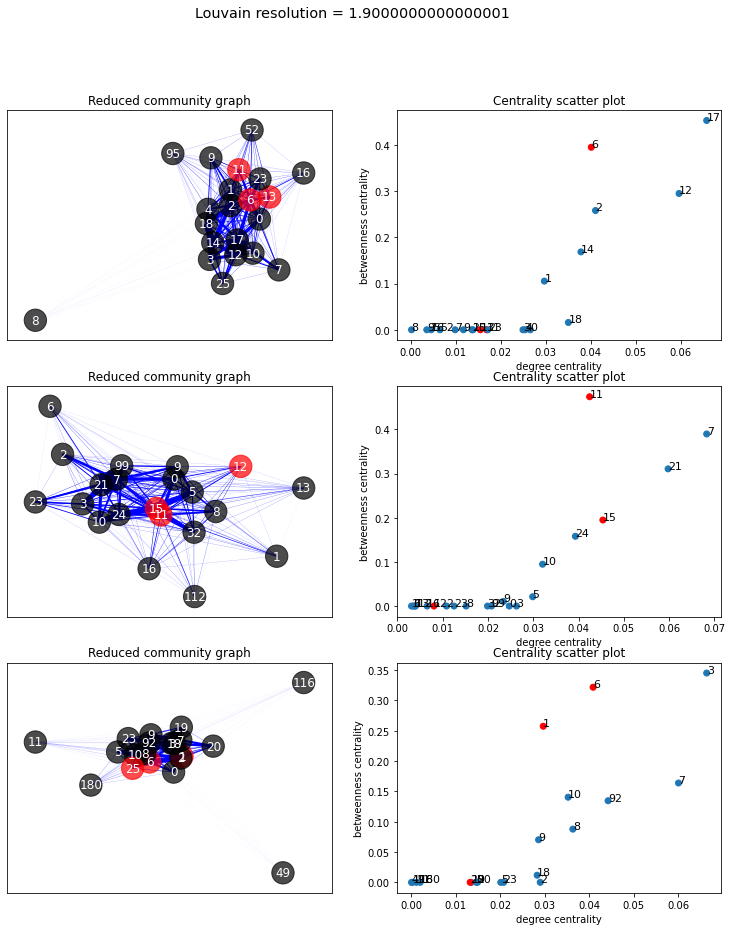

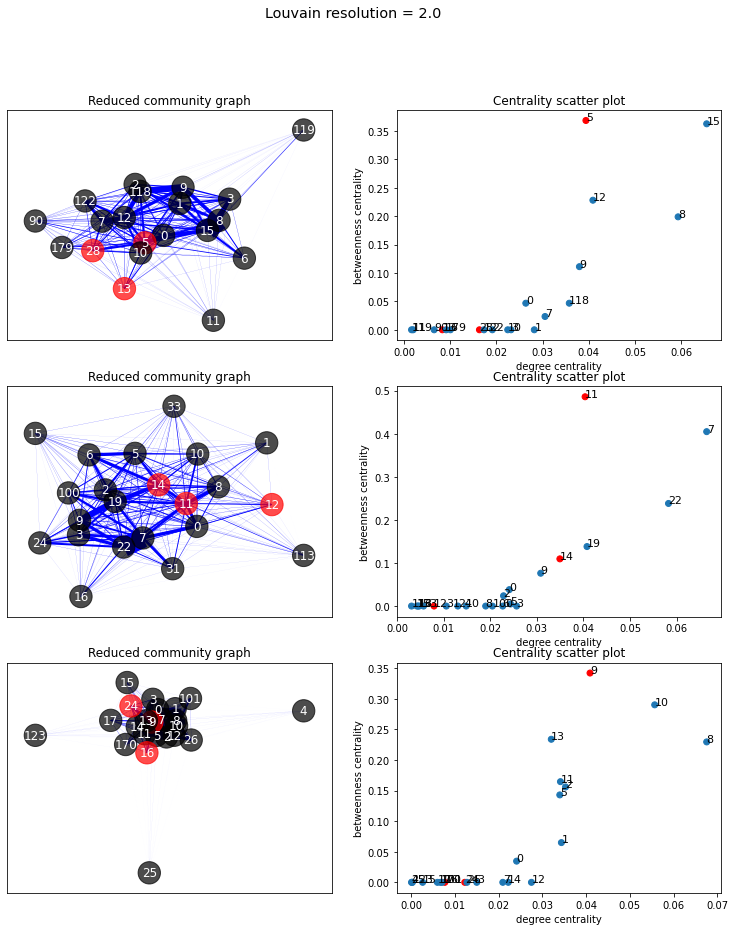

In [31]:
for res in tqdm(np.linspace(0.5, 2, num=16)):
    full_process(resolution=res, repeats=3, save_filename=f'reduced-subgraph-figs/resolution-{res}.svg')